# SVM model for predicting impact position using datasets P1 based on **peaks** features - Sound

### Model Description

This notebook implements a Support Vector Machine (SVM) model to predict the position of an impact (C, S, V) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting the highest frequency **peaks** using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import sys

### Import Tool Functions

In [2]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

from readWavFolder import readWavFolder
from spectrumFromSignal import spectrumFromSignal
from extractPeakFromSignal import extractPeakFromSignal
p1_s_samples = "../../../Data/Sound/P1"

### Feature extraction example

213


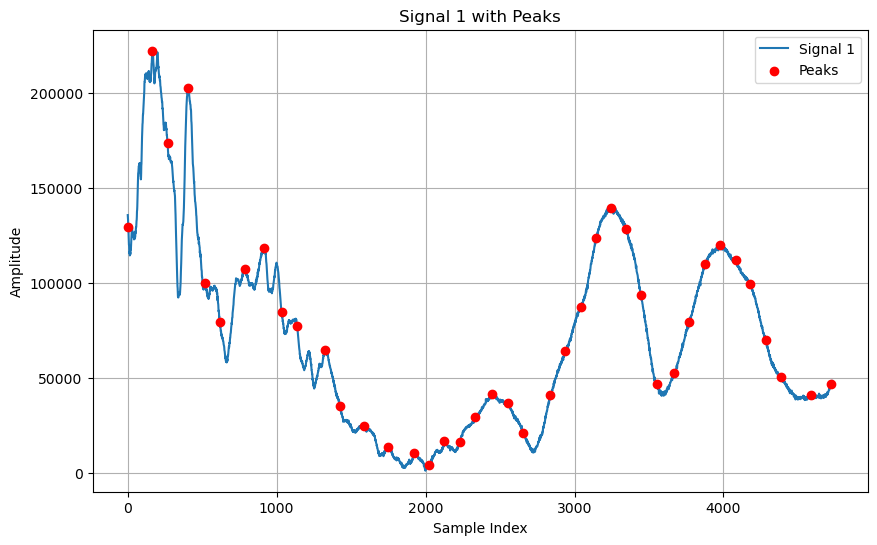

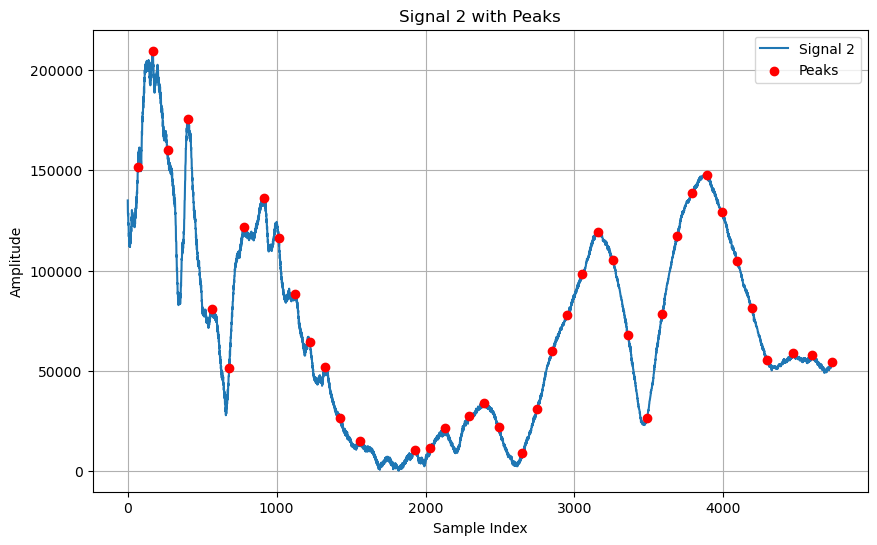

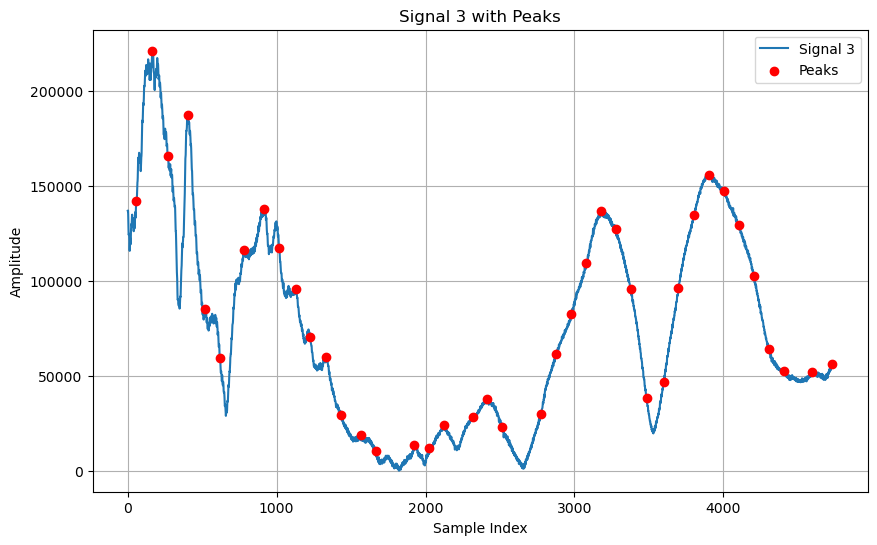

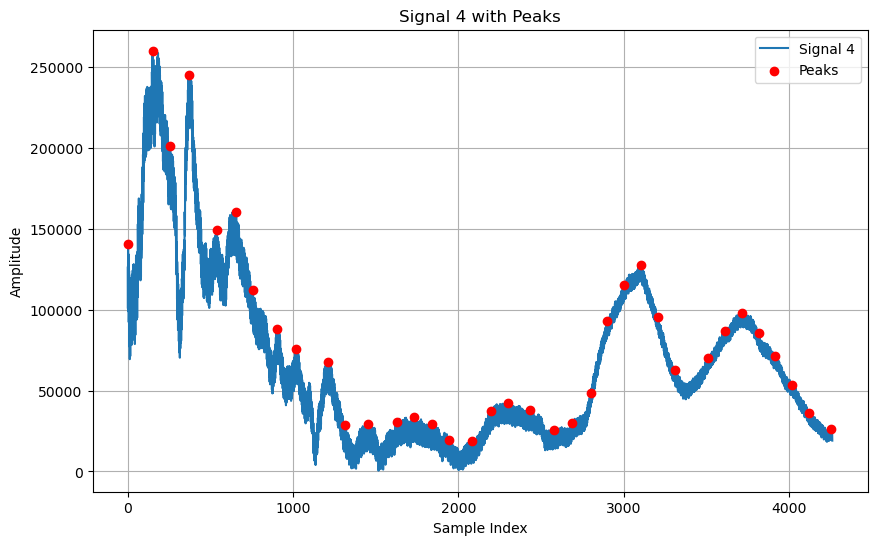

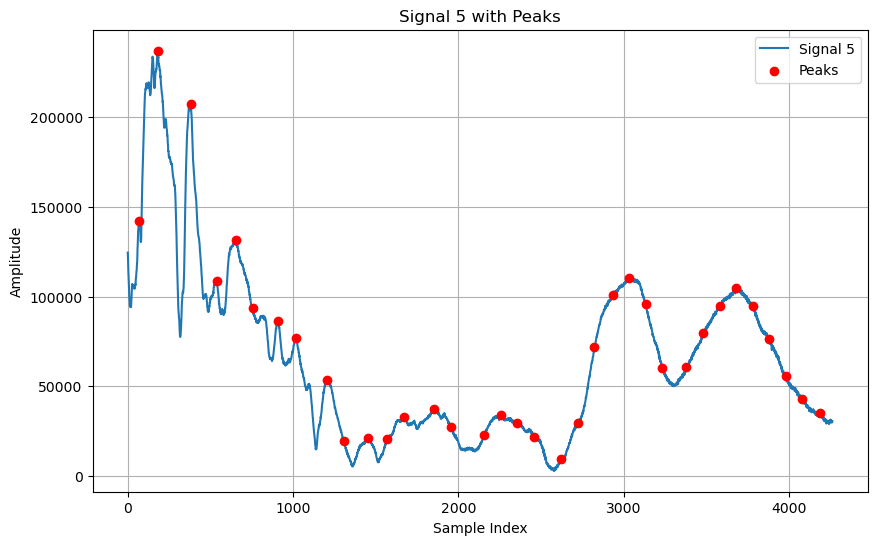

In [3]:
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")
print(len(samplerateVect))
for idx in range(5):  # Loop through the first 5 elements
    spectrum, _ = spectrumFromSignal(testWavFileVect[idx], samplerateVect[idx])
    peaks, _ = extractPeakFromSignal(spectrum, smoothing=1, num_peaks=40)
    
    plt.figure(figsize=(10, 6))
    plt.plot(spectrum, label=f"Signal {idx + 1}")
    plt.scatter(peaks, spectrum[peaks], color="red", label="Peaks", zorder=5)
    plt.title(f"Signal {idx + 1} with Peaks")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

## Main

In [ ]:
results = []

for n_peak in range(1, 22, 3):
    print(f'Processing n_peak: {n_peak}')
    X_peaksHz = []
    X_peaksAmplitude = []
    Y_Label = []

    samplerateVect, WavFileVect, filesName = readWavFolder("../../../Data/Sound/P1")
    spectrumVect = []

    for i in range(len(WavFileVect)):
        spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
        spectrumVect.append(spectrum)

        peaks, props = extractPeakFromSignal(spectrum, num_peaks=n_peak)
        X_peaksHz.append(freqs[peaks])
        X_peaksAmplitude.append(spectrum[peaks])
        position = 1
        if "C" in filesName[i]:
            position = 1
        elif "S" in filesName[i]:
            position = 2
        elif "V" in filesName[i]:
            position = 3

        Y_Label.append(position)

    X_peaksAmplitude = [peak_val / np.max(peak_val) for peak_val in X_peaksAmplitude]

    max_length = max(max(len(p) for p in X_peaksHz), max(len(a) for a in X_peaksAmplitude))
    X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_peaksHz]
    X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_peaksAmplitude]

    X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(Y_Label)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train and evaluate SVC with different kernels
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        svc = SVC(kernel=kernel)
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_pred)

        y_train_pred = svc.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)

        results.append({
            'n_peak': n_peak,
            'kernel': kernel,
            'accuracy_train': accuracy_train,
            'accuracy_test': accuracy_test
        })

results_df = pd.DataFrame(results)


Processing n_peak: 1


KeyboardInterrupt: 

### Save the results

In [17]:
if os.path.exists("S_SVM_Position_P1_Peaks.xlsx"):
    os.remove("S_SVM_Position_P1_Peaks.xlsx")
results_df.to_excel("S_SVM_Position_P1_Peaks.xlsx", index=False)
print(f'Results have been saved to {"S_SVM_Position_P1_Peaks.xlsx"}.')

Results have been saved to S_SVM_Position_P1_Peaks.xlsx.


### Computing the best model

In [20]:
# Get the best configuration
best_config = results_df.loc[results_df['accuracy_test'].idxmax()]
best_accuracy = best_config['accuracy_test']
best_kernel = best_config['kernel']
best_n_peak = int(best_config['n_peak'])

print(f"Best Hyperparameters:")
print(f"  accuracy test: {best_accuracy}")
print(f"  kernel: {best_kernel}")
print(f"  n_peak: {best_n_peak}")

# Extract features again for the best n_peak
X_peaksHz = []
X_peaksAmplitude = []
Y_Label = []

for i in range(len(WavFileVect)):
    spectrum, freqs = spectrumFromSignal(WavFileVect[i], samplerateVect[i])
    peaks, props = extractPeakFromSignal(spectrum, num_peaks=best_n_peak)
    X_peaksHz.append(freqs[peaks])
    X_peaksAmplitude.append(spectrum[peaks])
    position = 1
    if "C" in filesName[i]:
        position = 1
    elif "S" in filesName[i]:
        position = 2
    elif "V" in filesName[i]:
        position = 3
    Y_Label.append(position)

X_peaksAmplitude = [peak_val / np.max(peak_val) for peak_val in X_peaksAmplitude]
max_length = max(max(len(p) for p in X_peaksHz), max(len(a) for a in X_peaksAmplitude))
X_peaksHz_padded = [np.pad(p, (0, max_length - len(p)), constant_values=0) for p in X_peaksHz]
X_peaksAmplitude_padded = [np.pad(a, (0, max_length - len(a)), constant_values=0) for a in X_peaksAmplitude]
X = np.hstack((np.array(X_peaksHz_padded), np.array(X_peaksAmplitude_padded)))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model with the best configuration
svm_best = SVC(kernel=best_kernel)
svm_best.fit(X_train, y_train)

# Predict and visualize
y_pred_best = svm_best.predict(X_test)


Best Hyperparameters:
  accuracy test: 0.627906976744186
  kernel: poly
  n_peak: 13


### Visualisation

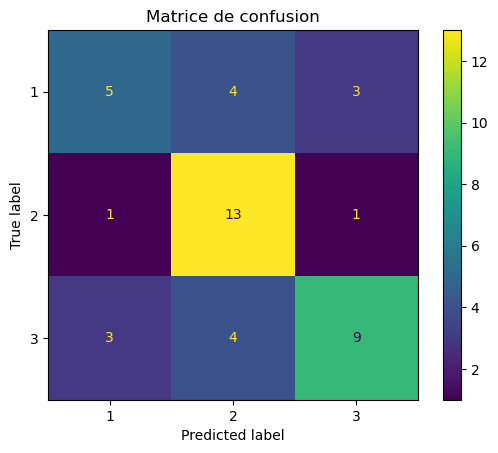

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()